In [1]:
%load_ext autoreload
%autoreload 2

Unlike many other machine learning domains, molecular featurization (i.e. the process of transforming a molecule into a vector) lacks a consistently good default. 
It is still an open question how to best capture the complexity of molecular data with a unified representation. Which molecular representation works best depends largely on which task you are modeling. To achieve optimal performance, it is wise to experiment with a variety of featurization schemes, from structural fingerprints to physicochemical descriptors and pre-trained embeddings.



## Use cases

Molecular representations / featurizers are an integral part of any molecular modelling workflow and are commonly used for:

- Search - to find molecules with similar electronic properties, similar structures, or similar biological activity for a target.
- Clustering - to group molecules based on their features and derive hypotheses around the relationship between structure and activity
- Modeling - to build QSAR model for molecular property/activity prediction

## Importance of the choice of molecular representation

To demonstrate the impact a featurizer can have, we establish two simple benchmarks:
1. To demonstrate the impact on modeling, we will use two datasets from [MoleculeNet](https://moleculenet.org/datasets-1) [1].
2. To demonstrate the impact on search, we will use the [RDKit Benchmarking Platform](https://github.com/rdkit/benchmarking_platform) [2, 3].

We will compare the performance of three different featurizers:
- **ECFP6** [4]: Binary, circular fingerprints where each bit indicates the presence of particular substructures of a radius up to 3 bonds away from an atom.
- **RDKit 2D** [5]: Continuous 2D descriptors from RDKit.
- **ChemBERTa** [6]: Learned representations from a pre-trained SMILES transformer model.


<div class="admonition tip highlight">
<p class="admonition-title">Tl;dr - Importance of molecular representation</p>
<p>
No featurizer consistently stood out for either task or even within a task category:

- **Modeling:**  The Rdkit featurizer outperforms the next best featurizer by ~20% on the _Lipophilicity_ prediction task. On _ClinTox_, however, things are reversed and ChemBERTa outperforms the other featurizers by ~about 18%. 

- **Search**: ECFP outperforms ChemBERTa and RDKit-2D and is the best option across the board, although it's target dependent.
    
These quick examples show the context-dependent nature and thus the importance of experimenting with trying different featurizers. **In short, the perfect molecular featurizer doesn’t exist (yet!)**. All have their pros and cons depending on the data and the downstream task.
</p>
</div>


### Modeling
We will compare the performance on two datasets using scikit-learn [AutoML](https://github.com/automl/auto-sklearn) [7, 8] models.

In [2]:
#! pip install "auto-sklearn"

In [3]:
import os
import tqdm
import fsspec
import pickle
import warnings
import numpy as np
import pandas as pd
import datamol as dm
import matplotlib.pyplot as plt
import autosklearn.classification
import autosklearn.regression
from collections import defaultdict
from rdkit.Chem import SaltRemover

from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

from molfeat.trans.fp import FPVecTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

In [4]:
# Making the output less verbose
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
dm.disable_rdkit_log()

In [5]:
def load_dataset(uri: str, readout_col: str):
    """Loads the MoleculeNet dataset"""
    df = pd.read_csv(uri)
    smiles = df["smiles"].values
    y = df[readout_col].values
    return smiles, y


def preprocess_smiles(smi):
    """Preprocesses the SMILES string"""
    mol = dm.to_mol(smi, ordered=True, sanitize=False)    
    try: 
        mol = dm.sanitize_mol(mol)
    except:
        mol = None
            
    if mol is None: 
        return
        
    mol = dm.standardize_mol(mol, disconnect_metals=True)
    remover = SaltRemover.SaltRemover()
    mol = remover.StripMol(mol, dontRemoveEverything=True)

    return dm.to_smiles(mol)


def scaffold_split(smiles):
    """In line with common practice, we will use the scaffold split to evaluate our models"""
    scaffolds = [dm.to_smiles(dm.to_scaffold_murcko(dm.to_mol(smi))) for smi in smiles]
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    return next(splitter.split(smiles, groups=scaffolds))


In [6]:
# Setup the featurizers
trans_ecfp = FPVecTransformer(kind="ecfp:6", n_jobs=-1)
trans_desc2D = FPVecTransformer(kind="desc2D", replace_nan=True, n_jobs=-1)
trans_chemberta = PretrainedHFTransformer(kind='ChemBERTa-77M-MLM', notation='smiles')

#### Lipophilicity
Lipophilicity is a regression task with 4200 molecules

In [7]:
# Prepare the Lipophilicity dataset
smiles, y_true = load_dataset("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv", "exp")
smiles = np.array([preprocess_smiles(smi) for smi in smiles])
smiles = np.array([smi for smi in smiles if dm.to_mol(smi) is not None])

feats_ecfp, ind_ecfp = trans_ecfp(smiles, ignore_errors=True)
feats_desc2D, ind_desc2D = trans_desc2D(smiles, ignore_errors=True)
feats_chemberta, ind_chemberta = trans_chemberta(smiles, ignore_errors=True)

X = {
    "ECFP": feats_ecfp[ind_ecfp],
    "RDKit2D": feats_desc2D[ind_desc2D],
    "ChemBERTa": feats_chemberta[ind_chemberta],
}

In [17]:
# Train a model
train_ind, test_ind = scaffold_split(smiles)

lipo_scores = {}
for name, feats in X.items():
    
    # Train
    automl = autosklearn.regression.AutoSklearnRegressor(
        memory_limit=100000,
        # For practicality’s sake, limit this to 5 minutes! 
        # (x3 = 15 min in total)
        time_left_for_this_task=180,  
        seed=1,
    )
    automl.fit(feats[train_ind], y_true[train_ind])
    
    # Predict and evaluate
    y_hat = automl.predict(feats[test_ind])
    
    # Evaluate
    mae = mean_absolute_error(y_true[test_ind], y_hat)
    lipo_scores[name] = mae

lipo_scores

[WARNING] [2023-06-29 01:59:14,689:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 01:59:33,823:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 01:59:53,837:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 02:02:07,154:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 02:02:26,345:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 02:05:02,614:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 02:05:23,183:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 02:05:42,297:Client-EnsembleBuilder] No runs were available to build an ensemble from


{'ECFP': 0.7635259340171177,
 'RDKit2D': 0.6177996540765902,
 'ChemBERTa': 0.7432116709721998}

#### ClinTox

In [18]:
# Prepare the ClinTox dataset
smiles, y_true = load_dataset("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz", "CT_TOX")
smiles = np.array([preprocess_smiles(smi) for smi in smiles])
smiles = np.array([smi for smi in smiles if smi is not None])

feats_ecfp, ind_ecfp = trans_ecfp(smiles, ignore_errors=True)
feats_desc2D, ind_desc2D = trans_desc2D(smiles, ignore_errors=True)
feats_chemberta, ind_chemberta = trans_chemberta(smiles, ignore_errors=True)

X = {
    "ECFP": feats_ecfp[ind_ecfp],
    "RDKit2D": feats_desc2D[ind_desc2D],
    "ChemBERTa": feats_chemberta[ind_chemberta],
}

[02:07:48] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:56] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero
[02:07:57] Unusual charge on atom 0 number of radical electrons set to zero


In [21]:
# Train a model
train_ind, test_ind = scaffold_split(smiles)

clintox_scores = {}
for name, feats in X.items():
    
    # Train
    automl = autosklearn.classification.AutoSklearnClassifier(
        memory_limit=100000, 
        # For practicality’s sake, limit this to 5 minutes! 
        # (x3 = 15 min in total)
        time_left_for_this_task=180,
        n_jobs=4,
        seed=1,
    )
    automl.fit(feats[train_ind], y_true[train_ind])
    
    # Predict and evaluate
    y_hat = automl.predict_proba(feats[test_ind])
    y_hat = y_hat[:, 1]
    
    # Evaluate
    auroc = roc_auc_score(y_true[test_ind], y_hat)
    clintox_scores[name] = auroc

clintox_scores

[WARNING] [2023-06-29 02:14:14,256:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-06-29 02:14:15,754:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-06-29 02:17:16,461:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-06-29 02:17:18,727:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-06-29 02:17:19,883:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-06-29 02:17:48,626:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-06-29 02:17:51,431:Client-EnsembleBuilder] No 

{'ECFP': 0.5134722222222222,
 'RDKit2D': 0.5236111111111111,
 'ChemBERTa': 0.6402777777777777}

#### Conclusion

| Dataset       | Metric   | Representation | Score | Rank |
|---------------|----------|----------------|-------|------|
| Lipophilicity | MAE ↓    | ECFP           | 0.764  | 1    |
|               |          | RDKit2D        | 0.618  | 0    |
|               |          | ChemBERTa      | 0.743  | 2    |
| ClinTox       | AUROC ↑  | ECFP           | 0.513  | 2    |
|               |          | RDKit2D        | 0.524  | 1    |
|               |          | ChemBERTa      | 0.640  | 0    |

We can see that for Lipophilicity, the RDKit2D featurizer proves most powerful, outperforming the next best featurizer by ~17%. For ClinTox, however, the results are reversed and it's instead ChemBERTa that outperforms the other featurizers by ~22%. This shows the importance of trying different featurizers. Luckily, with Molfeat, this is now much easier to do!


### Search
We will now evaluate the performance of the featurizers on various search tasks from the RDKit Benchmarking Platform [2, 3].

In [24]:
# Specify some meta-data

BASE_CMPD_URI = "https://github.com/rdkit/benchmarking_platform/raw/master/compounds/DUD/cmp_list_DUD"
CMPD_EXT = ".dat.gz"

BASE_SPLIT_URI = "https://github.com/rdkit/benchmarking_platform/raw/master/query_lists/data_sets_I/DUD/training_DUD"
SPLIT_EXT = ".pkl"

# Out of practicality, we only use the first 10 targets
TARGETS = [
    "ace",
    "ache",
    "ar",
    "cdk2",
    "cox2",
    "dhfr",
    "egfr",
    "er_agonist",
    "fgfr1",
    "fxa",
]

In [25]:
def get_compounds_for_target(target: str):
    """Loads the structural data"""
    df = pd.DataFrame()
    for subset in ["actives", "decoys"]:
        df_ = pd.read_csv(f"{BASE_CMPD_URI}_{target}_{subset}{CMPD_EXT}", sep="\t")
        df_["subset"] = subset
        df_["target"] = 1 if subset == "actives" else 0
        df = pd.concat([df, df_])
    return df


def get_train_decoy_split_for_target(target: str, no_of_actives: int = 20):
    """Loads the proposed split of the benchmark"""
    with fsspec.open(f"{BASE_SPLIT_URI}_{target}_{no_of_actives}{SPLIT_EXT}", "rb") as fd:
        data = pickle.load(fd)
    return data[:no_of_actives], data[no_of_actives:]

In [26]:
results = defaultdict(dict)

for target in tqdm.tqdm(TARGETS, leave=False):

    # Load the structures (i.e. SMILES)
    df = get_compounds_for_target(target)
    n_actives = len(df[df["subset"] == "actives"])

    smiles = df["SMILES"].values
    smiles = np.array([smi for smi in smiles if dm.to_mol(smi) is not None])

    # Featurize
    feats_ecfp, ind_ecfp = trans_ecfp(smiles, ignore_errors=True)
    feats_desc2D, ind_desc2D = trans_desc2D(smiles, ignore_errors=True)
    feats_chemberta, ind_chemberta = trans_chemberta(smiles, ignore_errors=True)

    X = {
        "ECFP": feats_ecfp[ind_ecfp],
        "RDKit2D": feats_desc2D[ind_desc2D],
        "ChemBERTa": feats_chemberta[ind_chemberta],
    }

    # Get the train-test split
    train_active_ind, train_decoy_ind = get_train_decoy_split_for_target(target, no_of_actives=20)
    train_decoy_ind = [i + n_actives for i in train_decoy_ind]

    for feat_name, feats in X.items():

        # Train the model
        knn = KNeighborsClassifier()
        train_ind = np.concatenate([train_active_ind, train_decoy_ind])
        test_ind = np.array([i for i in range(len(df)) if i not in train_ind])
        knn.fit(feats[train_ind], df.iloc[train_ind]["target"].values)

        # Get targets and predictions
        y_true = df.iloc[test_ind]["target"].values
        y_pred = knn.predict_proba(feats[test_ind])[:, 1]

        # Compute the recovery score
        auc = roc_auc_score(y_true, y_pred)
        results[feat_name][target] = auc

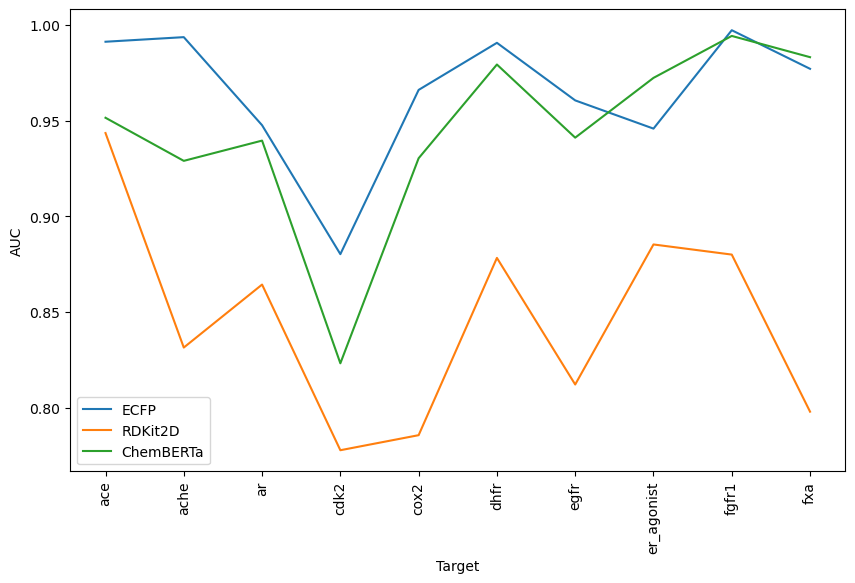

In [27]:
# Replicate the figure from https://doi.org/10.1021/ci400466r

xs = list(range(len(TARGETS)))

ecfp_scores = [results["ECFP"][target] for target in TARGETS]
desc2d_scores = [results["RDKit2D"][target] for target in TARGETS]
chemberta_scores = [results["ChemBERTa"][target] for target in TARGETS]

fig, ax = plt.subplots(figsize=(10, 6))
for scores, label in zip([ecfp_scores, desc2d_scores, chemberta_scores], ["ECFP", "RDKit2D", "ChemBERTa"]):
    ax.plot(xs, scores, label=label)

ax.set_xlabel("Target")
ax.set_ylabel("AUC")
ax.set_xticks(xs)
ax.set_xticklabels(TARGETS, rotation=90)
ax.legend()

#### Conclusion
For search, we observe yet again another ranking. It now seems that ECFP is the best option across the board, although it's target dependent. 


<div class="admonition info highlight">
<p class="admonition-title">Conclusion</p>
<p>
<b>There is no single "best" molecular featurizer.</b> With Molfeat, it is now easier than ever to experiment with a diverse set of popular featurizers to ensure you pick the best one for your task of interest!
</p>
</div>


## Citations
1. Wu, Z., Ramsundar, B., Feinberg, E. N., Gomes, J., Geniesse, C., Pappu, A. S., ... & Pande, V. (2018). MoleculeNet: a benchmark for molecular machine learning. Chemical science, 9(2), 513-530.
2. Riniker, S., Fechner, N., & Landrum, G. A. (2013). Heterogeneous classifier fusion for ligand-based virtual screening: or, how decision making by committee can be a good thing. Journal of chemical information and modeling, 53(11), 2829-2836.
3. Riniker, S., & Landrum, G. A. (2013). Open-source platform to benchmark fingerprints for ligand-based virtual screening. Journal of cheminformatics, 5(1), 26.
4. Rogers, D., & Hahn, M. (2010). Extended-connectivity fingerprints. Journal of chemical information and modeling, 50(5), 742-754.
5. Chithrananda, S., Grand, G., & Ramsundar, B. (2020). Chemberta: Large-scale self-supervised pretraining for molecular property prediction. arXiv preprint arXiv:2010.09885.
6. Efficient and Robust Automated Machine Learning Matthias Feurer, Aaron Klein, Katharina Eggensperger, Jost Springenberg, Manuel Blum and Frank Hutter Advances in Neural Information Processing Systems 28 (2015)
7. Auto-Sklearn 2.0: The Next Generation Matthias Feurer, Katharina Eggensperger, Stefan Falkner, Marius Lindauer and Frank Hutter* arXiv:2007.04074 [cs.LG], 2020
